# MIA attacks on Length-of-Stay predictor, Gated Recurrent Unit with Decay (GRU-D)
## Installation of Packages in Conda

To install the required packages in your conda environment, you can use the following commands:

```bash
conda install h5py
conda install pytables

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from torch import zeros

import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

from utils.data_processing import get_mimic_dataset, get_mimic_dataloaders

In [3]:
# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), "data/")

train_frac = 0.6
valid_frac = 0.0
test_frac = 0.0
early_stop_frac = 0.4
batch_size = 59
flatten = False # If LR, flatten the data

dataset, train_indices, validation_indices, test_indices, early_stop_indices= get_mimic_dataset(path,
                                                                            train_frac , 
                                                                            valid_frac,
                                                                            test_frac,
                                                                            early_stop_frac,
                                                                            flatten)

In [4]:
early_stop_indices 

[14366,
 14367,
 14368,
 14369,
 14370,
 14371,
 14372,
 14373,
 14374,
 14375,
 14376,
 14377,
 14378,
 14379,
 14380,
 14381,
 14382,
 14383,
 14384,
 14385,
 14386,
 14387,
 14388,
 14389,
 14390,
 14391,
 14392,
 14393,
 14394,
 14395,
 14396,
 14397,
 14398,
 14399,
 14400,
 14401,
 14402,
 14403,
 14404,
 14405,
 14406,
 14407,
 14408,
 14409,
 14410,
 14411,
 14412,
 14413,
 14414,
 14415,
 14416,
 14417,
 14418,
 14419,
 14420,
 14421,
 14422,
 14423,
 14424,
 14425,
 14426,
 14427,
 14428,
 14429,
 14430,
 14431,
 14432,
 14433,
 14434,
 14435,
 14436,
 14437,
 14438,
 14439,
 14440,
 14441,
 14442,
 14443,
 14444,
 14445,
 14446,
 14447,
 14448,
 14449,
 14450,
 14451,
 14452,
 14453,
 14454,
 14455,
 14456,
 14457,
 14458,
 14459,
 14460,
 14461,
 14462,
 14463,
 14464,
 14465,
 14466,
 14467,
 14468,
 14469,
 14470,
 14471,
 14472,
 14473,
 14474,
 14475,
 14476,
 14477,
 14478,
 14479,
 14480,
 14481,
 14482,
 14483,
 14484,
 14485,
 14486,
 14487,
 14488,
 14489,
 14490,


In [5]:
train_loader, validation_loader, test_loader, early_stop_loader = get_mimic_dataloaders(dataset,
                                                            train_indices, 
                                                            validation_indices, 
                                                            test_indices,
                                                            early_stop_indices,
                                                            batch_size)

In [6]:
best_hyperparams ={
    'cell_size': 58,
    'hidden_size': 78, 
    'learning_rate': 0.004738759319792616,
    'num_epochs':37,
    'patience': 5,
    'batch_size': 59,
    'seed': 4410,
    'min_delta': 0.0001,
    }
n_features = int(dataset.x.shape[1]/3)
X_mean = zeros(1,dataset.x.shape[2],n_features)

model_params = {k: best_hyperparams[k] for k in ['cell_size', 'hidden_size', 'batch_size']}

# Add other required parameters to model_params
model_params.update({
    'input_size': n_features,
    'X_mean': X_mean,
    'output_last': False
})

In [7]:
from tqdm import tqdm
from utils.grud import *

# Initialize the model with filtered parameters
model = GRUD(**model_params)

# Train the model with Train_Model function
train_losses, test_losses , train_acc, test_acc = gru_trained_model_and_metadata(
            model, train_loader, early_stop_loader,
            epochs=best_hyperparams['num_epochs'], 
            patience=best_hyperparams['patience'], 
            min_delta = best_hyperparams['min_delta'],
            learning_rate=best_hyperparams['learning_rate'], 
            batch_size=best_hyperparams['batch_size'],  # This might be used in your dataloaders, not directly in Train_Model
             metadata = None)

Model Structure:  GRUD(
  (zl): Linear(in_features=286, out_features=78, bias=True)
  (rl): Linear(in_features=286, out_features=78, bias=True)
  (hl): Linear(in_features=286, out_features=78, bias=True)
  (gamma_x_l): FilterLinear(in_features=104, out_features=104, bias=True)
  (gamma_h_l): Linear(in_features=104, out_features=78, bias=True)
  (fc): Linear(in_features=78, out_features=2, bias=True)
  (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)
Start Training ... 
Output type dermined by the model


Training Progress:   3%|▎         | 1/37 [00:10<06:20, 10.56s/it]

Epoch 0: Validation loss improved to 0.5731
Epoch: 0, train_loss: 0.69886546, valid_loss: 0.5731377, time: 10.57


Training Progress:   5%|▌         | 2/37 [00:20<05:59, 10.28s/it]

Epoch 1: Validation loss improved to 0.5530
Epoch: 1, train_loss: 0.62567394, valid_loss: 0.55299276, time: 10.08


Training Progress:   8%|▊         | 3/37 [00:30<05:46, 10.19s/it]

Epoch 2: No improvement. Patience counter: 1/5
Epoch: 2, train_loss: 0.61449519, valid_loss: 0.56087744, time: 10.08


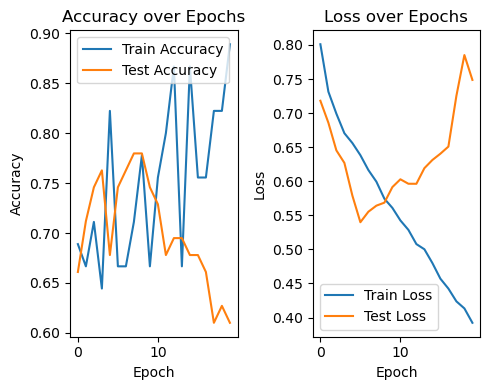

In [28]:
import matplotlib.pyplot as plt

# Convert losses to numpy-compatible lists directly
train_losses_cpu = [float(loss) for loss in train_losses]
test_losses_cpu = [float(loss) for loss in test_losses]

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
from mimic_gru_handler import MimicInputHandlerGRU

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(MimicInputHandlerGRU, config_path)

# Run the audit 
leakpro.run_audit()

2024-12-16 10:25:53,844 INFO     Target model blueprint created from GRUD in utils/grud.py.
2024-12-16 10:25:53,851 INFO     Loaded target model metadata from ./target_GRUD/model_metadata.pkl
2024-12-16 10:25:53,854 INFO     Loaded target model from ./target_GRUD
2024-12-16 10:25:54,559 INFO     Loaded population dataset from ./data/unflattened/dataset.pkl
2024-12-16 10:25:54,560 INFO     Loaded population dataset from ./data/unflattened/dataset.pkl
2024-12-16 10:25:54,560 INFO     Creating shadow model handler singleton
2024-12-16 10:25:54,564 INFO     Created folder ./leakpro_output/attack_objects/shadow_model
2024-12-16 10:25:54,564 INFO     Creating distillation model handler singleton
2024-12-16 10:25:54,568 INFO     Created folder ./leakpro_output/attack_objects/distillation_model
2024-12-16 10:25:54,569 INFO     Configuring RMIA attack
2024-12-16 10:25:54,570 INFO     Added attack: rmia
2024-12-16 10:25:54,570 INFO     Preparing attack: rmia
2024-12-16 10:25:54,570 INFO     Prep

No existing file named './leakpro_output/results/rmia/results.txt'. A new file will be created.


2024-12-16 11:04:56,652 INFO     Auditing completed


<Figure size 640x480 with 0 Axes>

## Report Genrating

In [ ]:
import sys
sys.path.append("../..")

# Import and initialize ReportHandler
from leakpro.reporting.report_handler import ReportHandler
# report_handler = ReportHandler()
report_handler = ReportHandler(report_dir="./leakpro_output/results")

# # Save Synthetic results using the ReportHandler
report_handler.save_results(attack_name="singling_out", result_data=sin_out_res)
report_handler.save_results(attack_name="linkability_risk", result_data=link_res)
report_handler.save_results(attack_name="inference_risk_base", result_data=inf_res)
report_handler.save_results(attack_name="inference_risk_worst", result_data=inf_res_worst)

# # Save GIA results using report handler
report_handler.save_results(attack_name="gia", result_data=GIA_result)

# Save MIA resuls using report handler
for res in mia_results:
    report_handler.save_results(attack_name=res.attack_name, result_data=res, config=res.configs)